In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

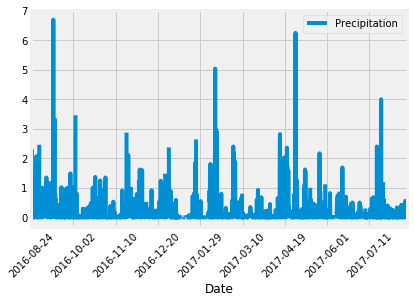

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Note: I had to look-up the last data point date from the hawaii_measurements.csv.

# find the last data point date

last_obs_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# split into year, month, year

date_parts = last_obs_date[0].split('-',3)


# convert the date into 3 integers
last_obs_year = int(date_parts[0])
last_obs_month = int(date_parts[1])
last_obs_day = int(date_parts[2])

a_year_from_last_obs = dt.datetime(last_obs_year,last_obs_month, last_obs_day) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= a_year_from_last_obs).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results,columns=['Date', 'Precipitation'])
precip_df = precip_df.sort_values('Date')
precip_df = precip_df.set_index(precip_df['Date'])
# Sort the dataframe by date
#precip_df = precip_df.sort_index()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45)
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_ranges = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter (Measurement.station =='USC00519281').all()
temp_ranges


[(54.0, 85.0, 71.66378066378067)]

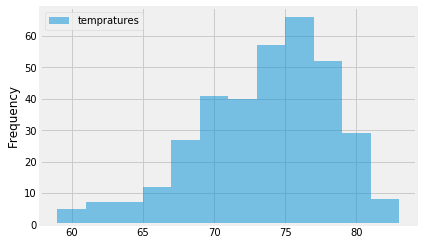

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281'). \
    filter(Measurement.date >= a_year_from_last_obs).all()
obs_df = pd.DataFrame(temp_observations, columns = ['tempratures'])
obs_df.plot.hist(bins=12, alpha = .5)
plt.show()

# Optional Analyses

## Temprature Analysis I: Is there a difference between observed tempratures in June vs. Decembver?

In [16]:
from scipy import stats

# Create a dataset for June temprature observations
june_temps = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs). \
        filter(func.strftime("%m", Measurement.date) == '06').all()
june_temps_df = pd.DataFrame(june_temps)
june_temps_df.set_index(['date'])


# Create a dataset for December temprature observations
december_temps = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs). \
        filter(func.strftime("%m", Measurement.date) == '12').all()
december_temps_df = pd.DataFrame(december_temps)
december_temps_df.set_index(['date'])



#Perform a Student T-Test

stats.ttest_ind(june_temps_df.tobs, december_temps_df.tobs)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### conclusion: the student t test shows p-value <.05; therefore there is a statistical difference betwee June and December tempratures

## Temprature Analysis II: Average Trip Temprature 

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# use the ravel method and convert the tuple to a list
trip_temps = list(np.ravel(calc_temps('2017-02-01', '2017-02-15')))

min_temp= trip_temps[0]
avg_temp = trip_temps[1]
max_temp = trip_temps[2]

//anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


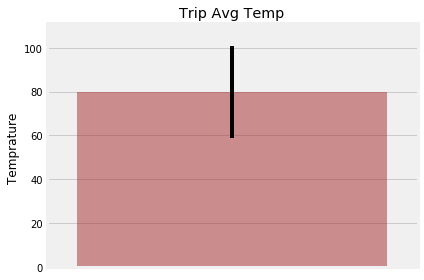

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


figure, ax = plt.subplots(figsize=(6,4))
x_position = 1
yerr = max_temp - min_temp

bar = ax.bar(x_position, max_temp , yerr=yerr, alpha=0.5, color='brown', align="center")
ax.set(xticks=range(x_position), xticklabels="a", title="Trip Avg Temp", ylabel="Temprature ")
ax.margins(.1, .1)
figure.tight_layout()
figure.show()


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station_query = \
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
              func.sum(Measurement.prcp)).\
              filter(Measurement.date >= '2017-02-01').\
              filter(Measurement.date <='2017-02-15'). \
              group_by(Station.name). \
              order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_per_station_df = pd.DataFrame(rainfall_per_station_query, 
        columns =['Station ID', 'Station Name', 'Total Precipitation', 'Latitude', 'Longitude', 'Elevation'])

rainfall_per_station_df

,Station ID,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,33.57
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,33.57
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,33.57
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,33.57
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,33.57
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,33.57
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.57
7,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,33.57
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,33.57


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Daily temprature normals matching the trip month and days

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-02-01'
trip_end = '2018-02-15'

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_m_d = trip_date_range.strftime('%m-%d')



# Loop through the list of %m-%d strings and calculate the normals for each date

normals=[]
for day in trip_m_d:
    daily_norm = daily_normals(day)
    #normals.append(daily_nrom)
    normals.extend(daily_norm)
normals

[(56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(normals, columns=['min temp', 'avg temp', 'max temp'])
daily_norms_df['Date'] =trip_date_range 
daily_norms_df.set_index(['Date'], inplace=True)
daily_norms_df.head()

,min temp,avg temp,max temp
Date,,,
2018-02-01,56.0,68.140351,78.0
2018-02-02,59.0,68.859649,77.0
2018-02-03,58.0,67.796610,77.0
2018-02-04,61.0,68.140351,76.0
2018-02-05,59.0,69.684211,80.0


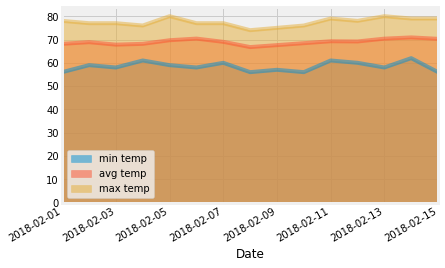

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', stacked=False,x_compat=True)
plt.show()